In [0]:
import numpy as np 
import pandas as pd 
from scipy.special import softmax
import matplotlib.pyplot as plt 
%matplotlib inline

In [0]:
class n_armed_bandit:
  def __init__(self, n, mu_n='random'):
    self.n = n
    if type(mu_n) == list:
      self.mu_n = mu_n
    elif mu_n == 'random':
      self.mu_n = np.random.normal(0, 1, n)
    print(self.mu_n)
    
    self.r_seq = [[]] * self.n
    self.q = [0.0] * self.n
    self.q_hist = [[0.0] * self.n]
    self.total_mean_reward = 0.0
  
  """
  action selection: e-greedy, softmax
  value method: mean, incremental
  """
  def pull(self, eps=0.0, temp=1, a_mode='e-greedy', q_mode='mean', step_size=None):
    notyet_visited = list(filter(lambda x: len(x[1]) == 0, list(zip(range(self.n), self.r_seq))))
    if len(notyet_visited) > 0:
      notyet_visited = np.array(notyet_visited).T[0]
      a = np.random.choice(notyet_visited)
    elif a_mode == 'e-greedy':
      p = np.random.rand()
      if eps == 0.0 or p < eps:
        a = np.random.choice(self.n)
      else:
        a = np.argmax(self.q)
    elif a_mode == 'softmax':
      pp = softmax(np.array(self.q) / temp)
      a = np.random.choice(self.n, p=pp)
    
    r = np.random.normal(self.mu_n[a], 1)
    self.total_mean_reward = self.total_mean_reward + (r - self.total_mean_reward)/len(self.q_hist)
    self.r_seq[a] = self.r_seq[a] + [r]

    tmp = [0.0] * self.n
    if q_mode == 'mean':
      for i in range(self.n):
        if len(self.r_seq[i]) > 0:
          tmp[i] = np.mean(self.r_seq[i])
        else:
          tmp[i] = 0.0
    elif q_mode == 'incremental':
      for i in range(self.n):
        if step_size is None:
          discount = 1/(len(self.q_hist) + 1)
        else:
          discount = step_size
        tmp[i] = self.q[i] + discount * (r - self.q[i])
    #print(tmp)
    self.q = tmp
    self.q_hist = self.q_hist + [tmp]

  def reset(self, initial_q=0.0):
    self.r_seq = [[]] * self.n
    self.q = [initial_q] * self.n
    self.q_hist = [[initial_q] * self.n]
    self.total_mean_reward = 0.0

  def experiment(self, n_step, eps=0.0, temp=1, a_mode='e-greedy', q_mode='mean', step_size=None, initial_q=0.0):
    self.reset(initial_q)

    reward_change = []
    for _ in range(n_step):
      self.pull(eps, temp, a_mode, q_mode, step_size)
      reward_change.append(self.total_mean_reward)

    return reward_change

In [0]:
def comparison_figure(x_points, y_points_list, label_list, x_label_name, y_label_name):
  plt.figure()
  for i, l in enumerate(label_list):
    plt.plot(list(x_points), list(y_points_list[i]), label=l)
  plt.legend()
  plt.xlabel(x_label_name)
  plt.ylabel(y_label_name)

In [126]:
mu_10 = list(np.random.normal(0, 1, 10))
nab = n_armed_bandit(5, mu_n=mu_10)

[0.9019991190741616, 1.405400370436751, 0.7886647281751082, -0.24409134935321894, 0.08984886843140429, -0.8719001874028603, 0.9290106610421506, -0.319671760742932, 0.21185020298831908, 1.745084434961361]


---epsilon 0.0---
---epsilon 0.01---
---epsilon 0.1---
CPU times: user 33.2 s, sys: 980 ms, total: 34.1 s
Wall time: 31.9 s


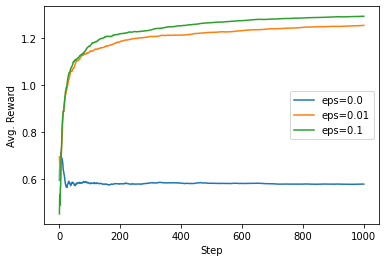

In [127]:
### e-greedy comparison btw eps in [0, 0.01, 0.1] with q_mode = mean
%%time
mean_rewards = {}
optimal_ratio = {}
for e in [0.0, 0.01, 0.1]:
  print('---epsilon '+str(e)+'---')
  tmp = []
  for i in range(100):
    tmp.append(nab.experiment(1000, eps=e))
  mean_rewards['eps='+str(e)] = np.mean(tmp, axis=0)
comparison_figure(list(range(1, 1001)), list(mean_rewards.values()), list(mean_rewards.keys()), 'Step', 'Avg. Reward')

---temparature 0.3---
---temparature 0.5---
---temparature 1.0---
CPU times: user 1min 6s, sys: 2.36 s, total: 1min 8s
Wall time: 1min 4s


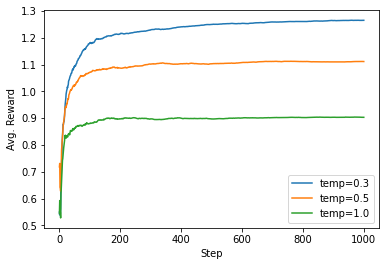

In [128]:
### softmax comparison btw temp in [0.3, 0.5, 1.0] with q_mode = mean
%%time
mean_rewards = {}
for t in [0.3, 0.5, 1.0]:
  print('---temparature '+str(t)+'---')
  tmp = []
  for i in range(100):
    tmp.append(nab.experiment(1000, temp=t, a_mode='softmax'))
  mean_rewards['temp='+str(t)] = np.mean(tmp, axis=0)
comparison_figure(list(range(1, 1001)), list(mean_rewards.values()), list(mean_rewards.keys()), 'Step', 'Avg. Reward')

---epsilon 0.0, initial_q 0.0---
---epsilon 0.0, initial_q 5.0---
---epsilon 0.1, initial_q 0.0---
---epsilon 0.1, initial_q 5.0---
CPU times: user 8.36 s, sys: 174 ms, total: 8.54 s
Wall time: 8.3 s


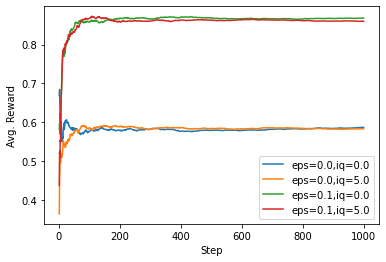

In [129]:
### epsilon in [0.0, 0.1] X initial_q in [0.0, 5.0] with a_mode = e-greedy, q_mode = incremental
%%time
mean_rewards = {}
for e in [0.0, 0.1]:
  for iq in [0.0, 5.0]:
    print('---epsilon '+str(e)+', initial_q '+str(iq)+'---')
    tmp = []
    for i in range(100):
      tmp.append(nab.experiment(1000, eps=e, initial_q=iq, q_mode='incremental'))
    mean_rewards[f"eps={e},iq={iq}"] = np.mean(tmp, axis=0)
comparison_figure(list(range(1, 1001)), list(mean_rewards.values()), list(mean_rewards.keys()), 'Step', 'Avg. Reward')

---epsilon 0.0, step_size 0.5---
---epsilon 0.0, step_size 0.9---
---epsilon 0.1, step_size 0.5---
---epsilon 0.1, step_size 0.9---
CPU times: user 7.47 s, sys: 23 ms, total: 7.49 s
Wall time: 7.47 s


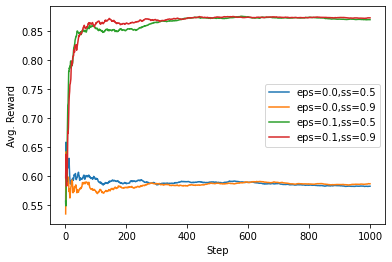

In [130]:
### epsilon in [0.0, 0.1] X step_size in [0.5, 0.9] with a_mode = e-greedy, q_mode = incremental
%%time
mean_rewards = {}
for e in [0.0, 0.1]:
  for s in [0.5, 0.9]:
    print('---epsilon '+str(e)+', step_size '+str(s)+'---')
    tmp = []
    for i in range(100):
      tmp.append(nab.experiment(1000, eps=e, q_mode='incremental', step_size=s))
    mean_rewards[f"eps={e},ss={s}"] = np.mean(tmp, axis=0)
comparison_figure(list(range(1, 1001)), list(mean_rewards.values()), list(mean_rewards.keys()), 'Step', 'Avg. Reward')